In [ ]:
import pandas as pd
from helpers import get_character_by_id, compare_race, convert_age
import seaborn as sns
import numpy as np
sns.set(style="white")

## Data Cleaning

We'll use these fields:
- subject
- trial
- character
- input (pres positon)
- output (choice position)
- chosen (true or false)
- condition
- character features
- subject features
- time
- subj_college (true false)
- self_confidence
- subj_deception (true false)
- Also need counts of shared features across subjects and characters

In [2]:
characters = pd.read_csv('characters_list.csv')

df = pd.read_csv(
    '4-16-data.csv', 
    names=['subject', 'subj_race', 'subj_age', 'subj_gender', 'condition', 'pres_order', 'choice_order', 'extras', 'submission', 'college_degree', 'self_ability', 'awareness'])

merged = {
    "subject": [],
    "trial": [],
    "character": [],
    "input": [],
    "output": [],
    "chosen": [],
    "condition": [],
    "subject_race": [],
    "subject_age": [],
    "subject_gender": [],
    "character_race": [],
    "character_age": [],
    "character_gender": [],
    "timestamp": [],
    "subj_college": [],
    "self_ability": [],
    "awareness": [],
    "shared_features": [],
}

for trial_index, row in df.iterrows():
    if pd.isna(row['condition']):
        continue
    character_pres = [int(each) for each in row['pres_order'].split(',') if each != '']
    character_choices = [int(each) for each in row['choice_order'].split(',') if each != '']

    for pres_index, character in enumerate(character_pres):
        character_info = get_character_by_id(character, characters)
        merged['subject'].append(row['subject'])
        merged['trial'].append(trial_index)
        merged['character'].append(character)
        merged['input'].append(pres_index)
        merged['chosen'].append(character in character_choices)
        if merged['chosen'][-1]:
            merged['output'].append(character_choices.index(character))
        else:
            merged['output'].append(np.nan)
        if 'control' in row['condition'].lower():
            merged['condition'].append('control')
        else:
            merged['condition'].append('experimental')
        merged['subject_race'].append(row['subj_race'])
        merged['subject_age'].append(convert_age(row['subj_age']))
        merged['subject_gender'].append(row['subj_gender'])
        merged['character_race'].append(character_info['Race'])
        merged['character_age'].append(character_info['Age'])
        merged['character_gender'].append(character_info['Gender'])
        merged['timestamp'].append(row['submission'])
        merged['subj_college'].append(row['college_degree'] == 'yes')
        merged['self_ability'].append(int(row['self_ability']))
        merged['awareness'].append(row['awareness'] == 'yes')

        shared_features = 0
        shared_features += compare_race(character_info['Race'], row['subj_race'])
        shared_features += character_info['Age'] == convert_age(row['subj_age'])
        shared_features += character_info['Gender'] == row['subj_gender']
        merged['shared_features'].append(shared_features)

data = pd.DataFrame(merged)

In [3]:
data = data.query('awareness == False')
data.head()

,subject,trial,character,input,output,chosen,condition,subject_race,subject_age,subject_gender,character_race,character_age,character_gender,timestamp,subj_college,self_ability,awareness,shared_features
0,88,0,1,0,NaN,False,control,Asian-Pacific Islander,18-39,Male,Asian/Pacific Islander,18-39,Female,2024-03-30 16:05:38.143,True,7,False,2
1,88,0,18,1,4.0,True,control,Asian-Pacific Islander,18-39,Male,Latino,18-39,Male,2024-03-30 16:05:38.143,True,7,False,2
2,88,0,6,2,NaN,False,control,Asian-Pacific Islander,18-39,Male,Asian/Pacific Islander,60+,Male,2024-03-30 16:05:38.143,True,7,False,2
3,88,0,4,3,3.0,True,control,Asian-Pacific Islander,18-39,Male,Asian/Pacific Islander,18-39,Male,2024-03-30 16:05:38.143,True,7,False,3
4,88,0,8,4,NaN,False,control,Asian-Pacific Islander,18-39,Male,Black,40-59,Female,2024-03-30 16:05:38.143,True,7,False,0


## Basic Analyses

In [21]:
data.value_counts(['subject_age'])/16

subject_age
18-39          31.0
40-59          20.0
Under 18        4.0
60+             1.0
Name: count, dtype: float64

In [22]:
data.value_counts(['subject_gender'])/16

subject_gender
Male              40.0
Female            16.0
Name: count, dtype: float64

In [23]:
data.value_counts(['subject_race'])/16

subject_race          
Asian-Pacific Islander    42.0
White                      7.0
Other                      4.0
African-American           3.0
Name: count, dtype: float64

In [24]:
pd.pivot_table(data, index='shared_features', columns='condition', values='chosen', aggfunc='mean')

condition,control,experimental
shared_features,,
0,0.345794,0.394161
1,0.545455,0.529915
2,0.569892,0.544643
3,0.615385,0.692308


In [8]:
pd.pivot_table(data, index='output', columns='chosen', values='shared_features', aggfunc='mean')

chosen,True
output,
0.0,1.285714
1.0,1.089286
2.0,1.375000
3.0,1.178571
4.0,1.214286
5.0,1.000000
6.0,0.964286
7.0,0.910714


In [9]:
pd.pivot_table(data, index='input', columns='chosen', values='shared_features', aggfunc='mean')

chosen,False,True
input,,
0,1.037037,1.103448
1,0.545455,1.029412
2,0.705882,1.318182
3,0.971429,1.428571
4,0.774194,1.040000
5,0.735294,1.318182
6,0.742857,1.047619
7,1.103448,1.037037
8,0.840000,1.354839


In [10]:
pd.pivot_table(data, index='subject_race', columns='character_race', values='chosen', aggfunc='mean')

character_race,Asian/Pacific Islander,Black,Latino,White
subject_race,,,,
African-American,0.384615,0.500000,0.545455,0.583333
Asian-Pacific Islander,0.512346,0.473373,0.536585,0.480226
Other,0.411765,0.631579,0.454545,0.470588
White,0.482759,0.619048,0.484848,0.448276


In [11]:
pd.pivot_table(data, index='subject_gender', columns='character_gender', values='chosen', aggfunc='mean')

character_gender,Female,Male
subject_gender,,
Female,0.572650,0.438849
Male,0.449231,0.552381


In [12]:
pd.pivot_table(data, index='subject_age', columns='character_age', values='chosen', aggfunc='mean')

character_age,18-39,40-59,60+
subject_age,,,
18-39,0.616766,0.467532,0.417143
40-59,0.594340,0.565657,0.356522
60+,0.600000,0.666667,0.375000
Under 18,0.608696,0.521739,0.333333


In [13]:
pd.pivot_table(data, index='subject_age', columns=['condition', 'character_age'], values='chosen', aggfunc='mean')

condition       control                     experimental                    
character_age     18-39     40-59       60+        18-39     40-59       60+
subject_age                                                                 
18-39          0.609195  0.512821  0.384615     0.625000  0.421053  0.452381
40-59          0.742857  0.657143  0.166667     0.521127  0.515625  0.465753
60+                 NaN       NaN       NaN     0.600000  0.666667  0.375000
Under 18       0.700000  0.545455  0.272727     0.538462  0.500000  0.428571

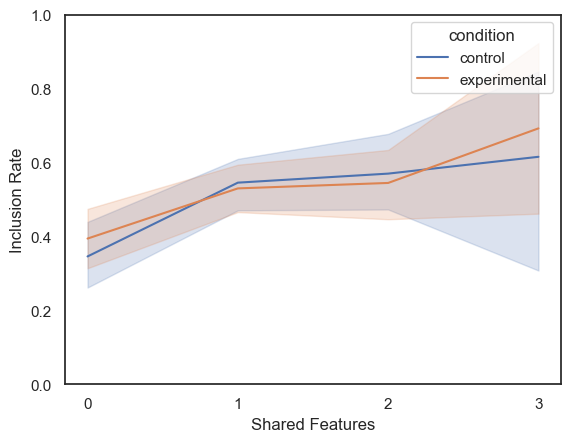

In [14]:
g = sns.lineplot(
    data=data, 
    x='shared_features', y='chosen', hue='condition')
g.set_xlabel('Shared Features')
g.set_xticks([0, 1, 2, 3])
g.set_ylim(0, 1)
g.set_ylabel('Inclusion Rate');

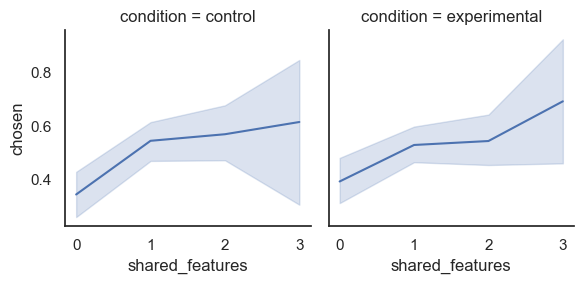

In [15]:
g = sns.FacetGrid(data, col='condition', sharey=True)
g.map(sns.lineplot, 'shared_features', 'chosen')

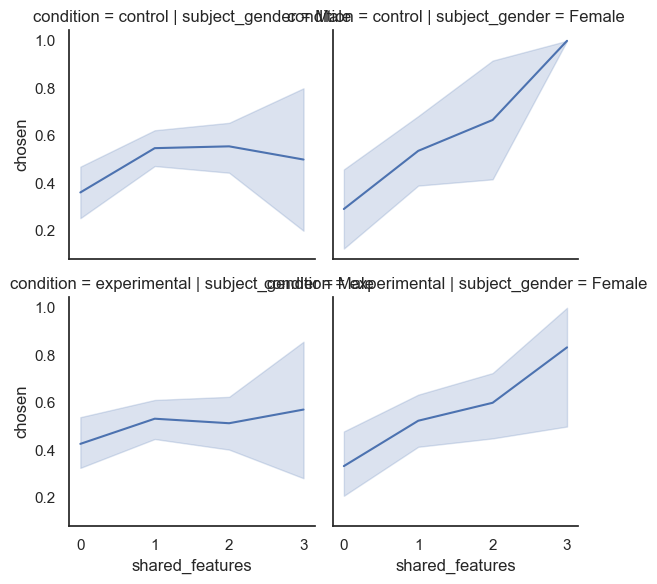

In [27]:
g = sns.FacetGrid(data, col='subject_gender', row='condition', sharey=True)
g.map(sns.lineplot, 'shared_features', 'chosen')

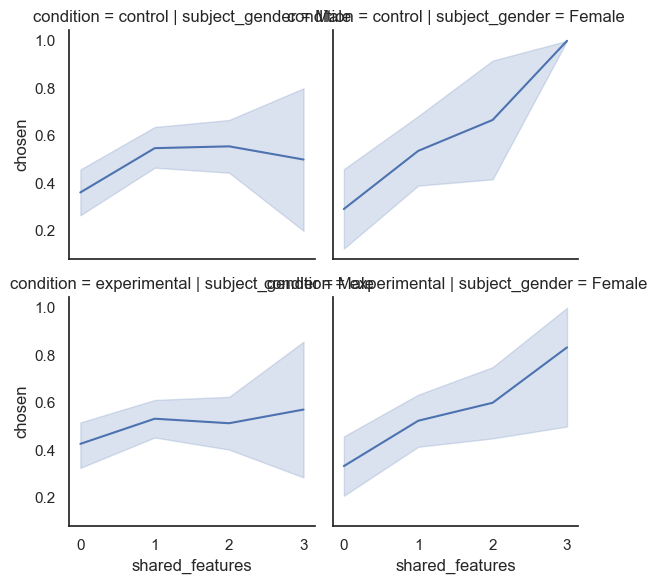

In [31]:
g = sns.FacetGrid(data, col='subject_gender', row='condition', sharey=True)
g.map(sns.lineplot, 'shared_features', 'chosen')

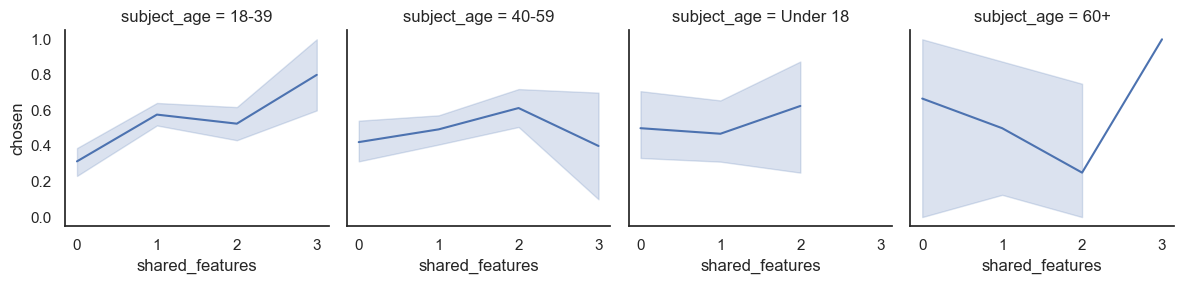

In [17]:
g = sns.FacetGrid(data, col='subject_age', sharey=True)
g.map(sns.lineplot, 'shared_features', 'chosen')

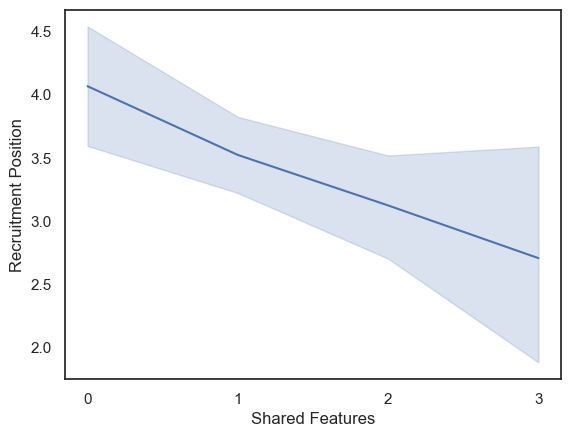

In [18]:
g = sns.lineplot(
    data=data, 
    y='output', x='shared_features')
g.set_ylabel('Recruitment Position')
g.set_xlabel('Shared Features')
g.set_xticks([0, 1, 2, 3]);

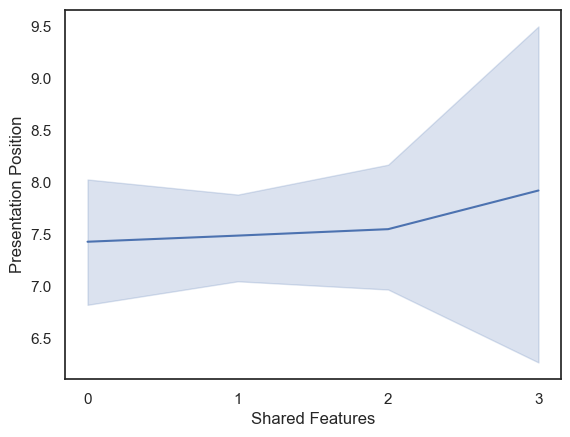

In [19]:
g = sns.lineplot(
    data=data, 
    y='input', x='shared_features'
    )
g.set_ylabel('Presentation Position')
g.set_xlabel('Shared Features')
g.set_xticks([0, 1, 2, 3]);

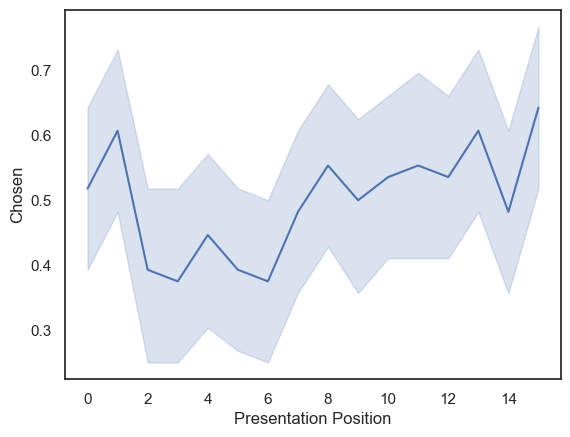

In [26]:
g = sns.lineplot(
    data=data, 
    x='input', y='chosen'
    )
g.set_xlabel('Presentation Position')
g.set_ylabel('Chosen');
